This notebook demonstrates the usage of SYREN-NEW emulators, organized into three main sections:
* [Test Linear Emulator](#test-linear-emulator): We validate our linear emulator by comparing it with results from CLASS simulation.
* [Test Nonlinear Emulator](#test-nonlinear-emulator): We compare the performance of our nonlinear emulator against EUCLIDEMULATOR2.
* [Test GPU implementation](#test-gpu-implementation): This section checks the consistency between PyTorch and NumPy implementations and benchmarks time efficiency on the GPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys
import os

# Add the path to the symbolic_pofk module
sys.path.append(os.path.join(sys.path[0], 'symbolic_pofk'))

import symbolic_pofk.linear_new
import symbolic_pofk.syren_new

import importlib
importlib.reload(symbolic_pofk.linear_new)
importlib.reload(symbolic_pofk.syren_new)
from symbolic_pofk.linear_new import plin_new_emulated
from symbolic_pofk.syren_new import pnl_new_emulated


In [2]:
# define plot function for the test
from matplotlib import rcParams

rcParams['font.size'] = 20
rcParams["text.usetex"] = True

def plot_diff(ks, preds, truth):
    rela_diffs = (preds - truth) / truth
    percentiles =  np.percentile(rela_diffs, [50-34-13.6,50-34, 50, 50+34,50+34+13.6], axis=0)
    fig, ax = plt.subplots(1,1,figsize=(10,5),sharey=True)
    ax.plot(ks, percentiles[2], color='black')
    ax.fill_between(ks, percentiles[0], percentiles[-1], color='tab:red',label=r'2$\sigma$')
    ax.fill_between(ks, percentiles[1], percentiles[-2], color='tab:blue',label=r'1$\sigma$')
    ax.hlines(-0.01, ks[0], ks[-1], color='k',linestyles='dashed')
    ax.hlines(0.01, ks[0], ks[-1], color='k',linestyles='dashed')
    ax.hlines(0, ks[0], ks[-1], color='k',linestyles='dashed')
    ax.set_xscale('log')
    ax.set_xlabel(r'$k \ / \ h\,{\rm Mpc^{-1}}$')
    ax.set_ylabel(r'relative difference')
    ax.legend()
    ax.set_xlim(ks[0],ks[-1])
    plt.show()

## Generate a latin hypercube of Cosmological Parameters

In [3]:
def get_param_samples(n, seed):
    """
    Get n samples from a latin hypercube from uniform prior
    
    Args:
        :n (int): Number of sets of cosmological samples to obtain
        :seed (int): The random seems for the latin hypercube
        
    Returns:
        :cosmo_params (np.ndarray): Array of cosmological parameters of shape (n, number of parameters).
            The parameters are ordered 10^9 As, Om, Ob, h, ns, mnu, w0, wa, a
    """
    
    all_prior = [[1.7, 2.5],    # 10^9 As
                 [0.24, 0.40],  # Om 
                 [0.04, 0.06],  # Ob
                 [0.61, 0.73],  # h
                 [0.92, 1.00],  # ns
                 [0.00, 0.15],  # mnu
                 [-1.3, -0.7],  # w0
                 [-0.7, 0.5],   # wa
                 [0.00, 3.00],  # redshift
                ]

    # Generate samples
    d = len(all_prior)
    lh_sampler = stats.qmc.LatinHypercube(d, seed=seed)
    cosmo_params = lh_sampler.random(n)
    for i in range(d):
        cosmo_params[:,i] = all_prior[i][0] + (all_prior[i][1] - all_prior[i][0]) * cosmo_params[:,i]
        
    # Convert redshift to scale factor
    cosmo_params[:,-1] = 1 / (1 + cosmo_params[:,-1])
        
    return cosmo_params

In [4]:
#generate cosmological parameter samples
thetas = get_param_samples(100, 1)

#set up k values
kmin = 9e-3
kmax = 9
nk = 200
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

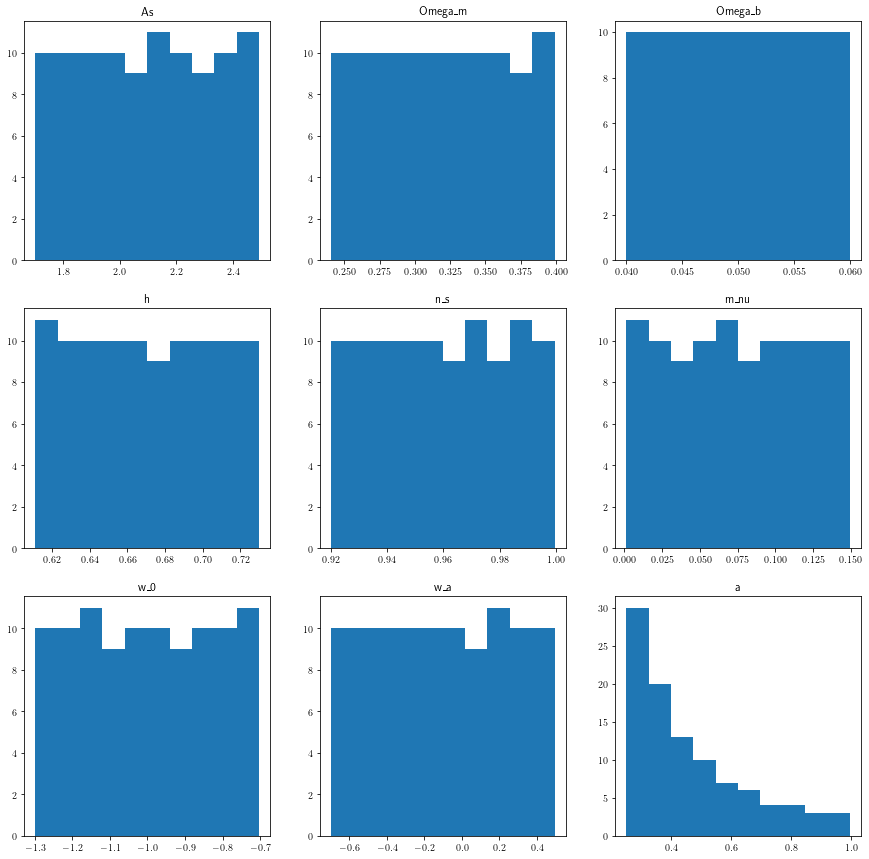

In [5]:
names = ['As','Omega_m', 'Omega_b', 'h', 'n_s', 'm_nu', 'w_0', 'w_a', 'a']
plt.subplots(3,3,figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.hist(thetas[:,i], bins=10)
    plt.title(names[i])

## Test Linear Emulator

In [6]:
# set up the CLASS simulator for comparison
from classy import Class
from classy import CosmoComputationError
import warnings

def get_class_linear(k, As, Om, Ob, h, ns, mnu, w0, wa, a):
    """
    Compute linear P(k) using class for the cosmology of interest
    
    Args:
        :k (np.ndarray): k values to evaluate P(k) at [h / Mpc]
        :As (float): 10^9 times the amplitude of the primordial P(k)
        :Om (float): The z=0 total matter density parameter, Omega_m
        :Ob (float): The z=0 baryonic density parameter, Omega_b
        :h (float): Hubble constant, H0, divided by 100 km/s/Mpc
        :ns (float): Spectral tilt of primordial power spectrum
        :mnu (float): Sum of neutrino masses [eV / c^2]
        :w0 (float): Time independent part of the dark energy EoS
        :wa (float): Time dependent part of the dark energy EoS
        :a (float): Scale factor to consider
        
    Returns:
        :plin_class (np.ndarray): Linear power spectrum at corresponding k values [(Mpc/h)^3]
    """
    
    Onu = mnu / 93.14 / h ** 2
    Oc =  Om - Ob - Onu
    redshift = 1 / a - 1
    
    class_params = {
        'h': h,
        'omega_b': Ob * h**2,
        'omega_cdm': Oc * h**2,
        'A_s': As*1.e-9,
        'n_s': ns,
        'output': 'mPk',
        'P_k_max_1/Mpc': k.max() * h,
        'w0_fld': w0,
        'wa_fld': wa,
        'Omega_Lambda': 0,  # Set to 0 because we're using w0_fld and wa_fld instead
        'tau_reio':0.0561,
        'z_max_pk': 3.0,  # Max redshift for P(k) output
    }

    class_params['N_ur'] = 0.00641  # To approximate standard 3.046
    class_params['N_ncdm'] = 3
    class_params['m_ncdm'] = ','.join([str(mnu/3.)]*3)
        
    cosmo = Class()
    cosmo.set(class_params)

    try:
        cosmo.compute()
    except CosmoComputationError as e:
        if "DeltaNeff < deltaN[0]" in str(e):
            # set YHe to 0.25. Value is from https://arxiv.org/abs/1503.08146 and Plank 2018(Section 7.6.1) https://arxiv.org/abs/1807.06209
            warnings.warn(f"Adjust YHe to 0.25 due to CLASS CosmoComputationError for cosmology {class_params}.")
            class_params['YHe'] = 0.25
            cosmo.set(class_params)
            cosmo.compute()
        else:
            raise e

    plin_class = np.array([cosmo.pk_lin(kk*h, redshift) for kk in k]) * h ** 3
    
    # Memory cleanup for class
    cosmo.struct_cleanup()
    cosmo.empty()

    return plin_class

In [7]:
%%time
# Compute the linear power spectrum using emulator 
plin_preds = [plin_new_emulated(ks,*t) for t in thetas]

CPU times: user 35.8 ms, sys: 2.96 ms, total: 38.8 ms
Wall time: 37.5 ms


In [8]:
%%time
# Compute the linear power spectrum using CLASS
plin_class = [get_class_linear(ks, *t) for t in thetas]

CPU times: user 13min 10s, sys: 1.47 s, total: 13min 12s
Wall time: 51.1 s


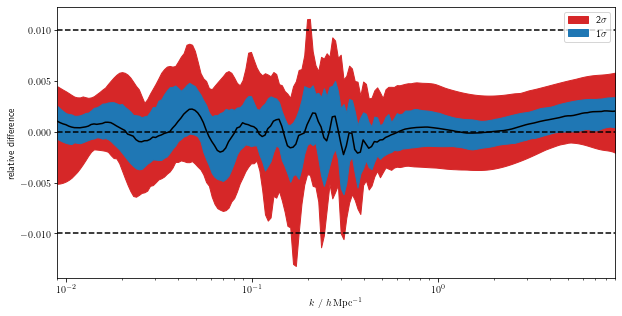

In [9]:
plin_preds = np.array(plin_preds)
plin_class = np.array(plin_class)

plot_diff(ks, plin_preds, plin_class)


## Test Nonlinear Emulator

In [10]:
# set up the EuclidEmulator2 simulator for comparison
import euclidemu2
ee2 = euclidemu2.PyEuclidEmulator()

def get_euclid_nonlinear(k, As, Om, Ob, h, ns, mnu, w0, wa, a):
    """
    Compute nonlinear P(k) using EuclidEmulator2 for the cosmology of interest
    
    Args:
        :k (np.ndarray): k values to evaluate P(k) at [h / Mpc]
        :As (float): 10^9 times the amplitude of the primordial P(k)
        :Om (float): The z=0 total matter density parameter, Omega_m
        :Ob (float): The z=0 baryonic density parameter, Omega_b
        :h (float): Hubble constant, H0, divided by 100 km/s/Mpc
        :ns (float): Spectral tilt of primordial power spectrum
        :mnu (float): Sum of neutrino masses [eV / c^2]
        :w0 (float): Time independent part of the dark energy EoS
        :wa (float): Time dependent part of the dark energy EoS
        :a (float): Scale factor to consider
        
    Returns:
        :pnl_euclid (np.ndarray): Nonlinear power spectrum at corresponding k values [(Mpc/h)^3]
    """
    
    redshift = 1/a - 1
    cosmo_par = {
        'As':As*1.e-9,
        'ns':ns,
        'Omb': Ob,
        'Omm': Om,
        'h': h,
        'mnu': mnu,
        'w': w0,
        'wa': wa,
    }
    k, b_euclid = ee2.get_boost(cosmo_par, [redshift], k)
    b_euclid = b_euclid[0]
    plin_euclid = get_class_linear(k, As, Om, Ob, h, ns, mnu, w0, wa, a)
    pnl_euclid = b_euclid * plin_euclid
    
    return pnl_euclid

In [11]:
%%time
# Compute the linear power spectrum using emulator 
pnl_preds = [pnl_new_emulated(ks,*t) for t in thetas]

CPU times: user 42 ms, sys: 1.99 ms, total: 44 ms
Wall time: 42.7 ms


In [12]:
%%time
# Compute the linear power spectrum using EuclidEmulator2
pnl_euclid = [get_euclid_nonlinear(ks, *t) for t in thetas]

CPU times: user 13min 13s, sys: 665 ms, total: 13min 14s
Wall time: 51.8 s


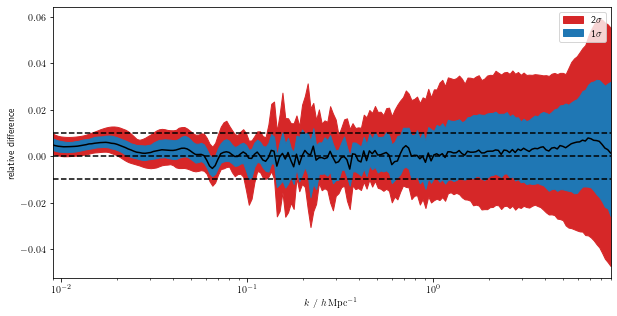

In [13]:
pnl_preds = np.array(pnl_preds)
pnl_euclid = np.array(pnl_euclid)

plot_diff(ks, pnl_preds, pnl_euclid)

## Test GPU implementation

In [14]:
from symbolic_pofk.pytorch.linear_new import plin_new_emulated as plin_new_emulated_torch
from symbolic_pofk.pytorch.syren_new import pnl_new_emulated as pnl_new_emulated_torch

import torch
# check gpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla V100-PCIE-32GB


In [15]:
#generate 2000 cosmological parameter samples
thetas = get_param_samples(2000, 0)

#set up k values
kmin = 9e-3
kmax = 9
nk = 200
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

### validate that cpu and gpu implementations are consistent

In [16]:
# cpu calculation
plin_preds_cpu = [plin_new_emulated(ks,*t) for t in thetas]
pnl_preds_cpu = [pnl_new_emulated(ks,*t) for t in thetas]

#gpu calculation
ks_tensor = torch.tensor(ks).to(device)
thetas_tensor = torch.tensor(thetas).to(device)
plin_preds_gpu = plin_new_emulated_torch(ks_tensor, thetas_tensor)
pnl_preds_gpu = pnl_new_emulated_torch(ks_tensor, thetas_tensor)

#convert to numpy
plin_preds_cpu = np.array(plin_preds_cpu)
pnl_preds_cpu = np.array(pnl_preds_cpu)
plin_preds_gpu = plin_preds_gpu.cpu().detach().numpy()
pnl_preds_gpu = pnl_preds_gpu.cpu().detach().numpy()

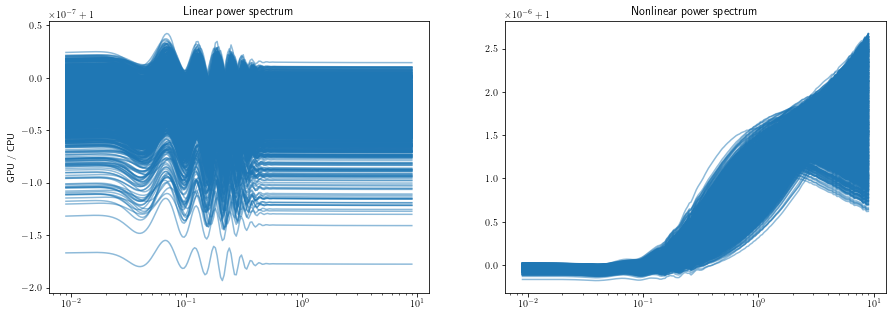

In [17]:

fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].semilogx(ks, (plin_preds_gpu/plin_preds_cpu).T,color='tab:blue',alpha=0.5)

axs[1].semilogx(ks, (pnl_preds_gpu/pnl_preds_cpu).T,color='tab:blue',alpha=0.5)

axs[0].set_title('Linear power spectrum')
axs[0].set_ylabel('GPU / CPU')
axs[1].set_title('Nonlinear power spectrum');

The relative difference between the two implementations is on the order of $10^{-7}$ and $10^{-6}$ due to numerical precision.

### Evaluate Runtmie

In [18]:
print('Runtime for CPU linear emulator:')
%timeit plin_preds_cpu = [plin_new_emulated(ks,*t) for t in thetas]

Runtime for CPU linear emulator:
418 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print('Runtime for GPU linear emulator:')
%timeit plin_preds_gpu = plin_new_emulated_torch(ks_tensor, thetas_tensor)

Runtime for GPU linear emulator:
3.3 ms ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print('Runtime for CPU nonlinear emulator:')
%timeit pnl_preds_cpu = [pnl_new_emulated(ks,*t) for t in thetas]

Runtime for CPU nonlinear emulator:
599 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print('Runtime for GPU nonlinear emulator:')
%timeit pnl_preds_gpu = pnl_new_emulated_torch(ks_tensor, thetas_tensor)

Runtime for GPU nonlinear emulator:
4.22 ms ± 9.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
